In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import os
import time
from tqdm import tqdm, tqdm_notebook
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, clear_output

In [2]:
data_dir = "/mnt/data/datasets/kitti/dataset/sequences/00/image_0/"

#TODO find actual camera matrix
cam_matrix = np.zeros((3,3), dtype=float)
cam_matrix[0,0] = 718.856 #fx
cam_matrix[0,2] = 607.1928 #cx
cam_matrix[1,2] = 185.2157 #cy
cam_matrix[1,1] = 718.856 #fy
cam_matrix[2,2] = 1

In [3]:
def init_flann():
    FLANN_INDEX_LSH = 6 #TODO look into params, maybe switch to bfmatcher
    index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 12, # 12
                   key_size = 20,     # 20
                   multi_probe_level = 2) #2
    search_params = dict(checks = 250)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    return flann

In [4]:
def flann_ratio_match(flann, des1, des2):
    matches = flann.knnMatch(des1, des2, k=2)
    #perform lowe's ratio test
    good = []
    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]
    # ratio test as per Lowe's paper
    for i,m_n in enumerate(matches):
        if (len(m_n) != 2): #TODO dont know what causes this
            #print("''''''''''''''''''''''''''''''''''''''''BOOP")
            continue
        m,n = m_n
        #TODO look into what actual ratio test
        if m.distance < 0.7*n.distance:
            matchesMask[i]=[1,0]
            good.append(m)
        
    return matches, matchesMask, good

In [5]:
def retrieve_trans(good_m, kp1, kp2):
    

    #translate matches to pixel cordinates... i thinl
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_m ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_m ]).reshape(-1,1,2)

    #find transformation and remve points that dont fit.
    E, mask = cv2.findEssentialMat(src_pts, dst_pts, cam_matrix, cv2.RANSAC, 0.999, 0.5)
    src_pts = src_pts[mask.ravel() == 1]
    dst_pts = dst_pts[mask.ravel() == 1]

    #find pose and remove points that dont fit
    #TODO maybe modify kp1 so that the next step doesnt use pts that dont fit
    retval, R, T, mask = cv2.recoverPose(E, src_pts, dst_pts, cam_matrix)
    src_pts = src_pts[mask.ravel() == 255]
    dst_pts = dst_pts[mask.ravel() == 255]
    
    #if no points fit, dont want to update translation or rotation
    if len(src_pts) == 0:
        T = np.zeros((3,1))
        R = np.identity(3)
                #return pts for drawing
    return T, R, dst_pts

In [6]:
#add two (T,R) pairs with axis correction C
def append_trans(pose, T2,R2, C):
    T = pose[0] + C.dot(pose[1]).dot(T2)
    R = pose[1].dot(R2)
    return (T,R)

In [7]:
def normalize(T):
    dem = (T[0]**2) + (T[1]**2) + (T[2]**2)
    dem = np.sqrt(dem)
    T = T/dem
    return T

In [8]:
def load_anno(anno_f):
    anno = ""
    with open(anno_f) as f:
        anno = f.readlines()
    #print(anno[:20])
    return anno

In [9]:
#returns actual pose from annotations
def get_actual_pos(anno, frame_id):
    ss = anno[frame_id].strip().split()
    return float(ss[3]), float(ss[7]), float(ss[11])

In [10]:
#get actual scale of the transformation from annotations
def get_abs_scale(anno, frame_id):
    x_p, y_p, z_p = get_actual_pos(anno, frame_id-1)
    x, y, z = get_actual_pos(anno, frame_id)
    act_T = (x-x_p,y-y_p,z-z_p)
    #print("x: %d\ny: %d\nz: %d" %(x,y,z))
    return np.sqrt(((x-x_p)**2) + ((y-y_p)**2) + ((z-z_p)**2)), act_T, (x,y,z)

In [11]:
class Scatter:
    def __init__(self, id, share=None, color_main="red", color_last="red", fig=None):
        self.color_main = color_main
        self.color_last = color_last
        self.pts = []
        self.kps = []
        if fig is None:
            self.fig = plt.figure()
        else:
            self.fig = fig
        plt.ion()

        
    def draw(self):
        return
        
    def add_pt(self, pt, kp):
        if kp:
            self.kps.append(pt)
        else:
            self.pts.append(pt)


In [12]:
class Scatter3D(Scatter):
    def __init__(self, id, title="", share=None, color_main="red", color_last="red", fig=None):
        super().__init__(id, share=share, color_main=color_main, color_last=color_last, fig=fig)
        self.ax = self.fig.add_subplot(id, projection='3d')
        self.ax.set_title(title)
        self.fig.show()
        self.fig.canvas.draw()
        
    def draw(self):
        self.ax.clear()
        np_pts = np.asarray(self.pts)
        self.ax.scatter(np_pts[...,0],np_pts[...,1],np_pts[...,2],color=self.color_main)
        #self.ax.scatter(self.xs[-1],self.ys[-1],self.zs[-1], color=self.color_last)
        self.fig.canvas.draw()
    

In [13]:
class Scatter2D(Scatter):
    def __init__(self, id, title="", share=None, color_main="red", color_last="red", fig=None):
        super().__init__(id, share=share, color_main=color_main, color_last=color_last, fig=fig)
        self.ax = self.fig.add_subplot(id, sharex=share, sharey=share)
        print(title)
        self.ax.set_title(title)
        self.fig.show()
        self.fig.canvas.draw()
        
    def draw(self):
        self.ax.clear()
        np_pts = np.asarray(self.pts)
        #print(np_pts.shape)
        if len(self.kps) is not 0:
            np_kps = np.asarray(self.kps)
            self.ax.scatter(np_kps[...,0], np_kps[...,1],color="black")
        if len(self.pts) is not 0:
            self.ax.scatter(np_pts[:-1,0],np_pts[:-1,1],color=self.color_main)
            self.ax.scatter(np_pts[-1,0],np_pts[-1,1],color=self.color_last)
        #self.ax.scatter(self.xs[-1],self.ys[-1],self.zs[-1], color=self.color_last)
        self.fig.canvas.draw()

In [14]:
orb = cv2.ORB_create(nfeatures=2500,WTA_K=2)
flann = init_flann()
anno = load_anno("/mnt/data/datasets/kitti/dataset/poses/00.txt")
C = np.asarray([[1,0,0],[0,-1,0],[0,0,-1]])

#         T                             R
pose = [np.zeros((3,1),dtype=float), np.identity(3,dtype=float)]

<IPython.core.display.Javascript object>


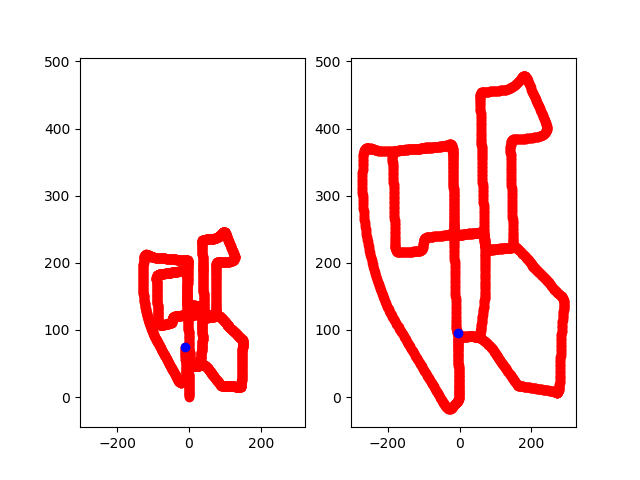

my pos
act pos


<IPython.core.display.Javascript object>


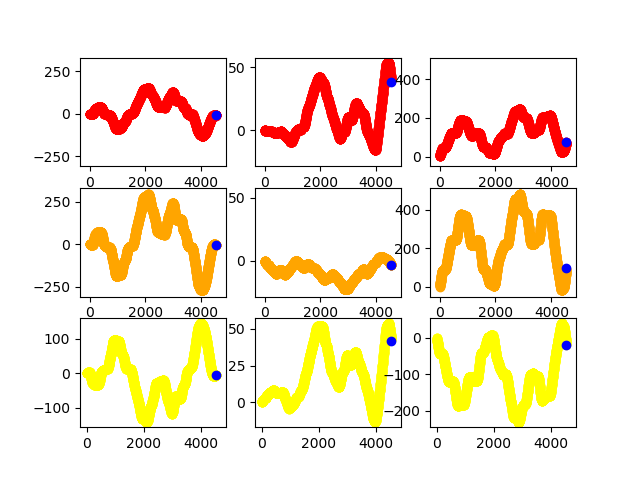

x pos
y pos
z pos
act x pos
act y pos
act z pos
x err
y err
z err


100%|██████████| 2270/2270 [03:43<00:00, 10.17it/s]


In [15]:
%matplotlib notebook

my_graph = Scatter2D(121, title="my pos", color_main="red", color_last="blue")
act_graph = Scatter2D(122, share=my_graph.ax, title="act pos", color_main="red", color_last="blue", fig=my_graph.fig)

#dx_graph = Scatter2D(231, title="dx pos", color_main="red", color_last="blue")
#dy_graph = Scatter2D(232, title="dy pos", color_main="orange", color_last="blue", fig=dx_graph.fig)
#dz_graph = Scatter2D(233, title="dz pos", color_main="orange", color_last="blue", fig=dx_graph.fig)
#act_dx_graph = Scatter2D(234, title="act dx pos", color_main="yellow", color_last="blue", fig=dx_graph.fig)
#act_dy_graph = Scatter2D(235, title="act dy pos", color_main="green", color_last="blue", fig=dx_graph.fig)
#act_dz_graph = Scatter2D(236, title="act dz pos", color_main="green", color_last="blue", fig=dx_graph.fig)

x_graph = Scatter2D(331, title="x pos", color_main="red", color_last="blue")
y_graph = Scatter2D(332, title="y pos", color_main="red", color_last="blue", fig=x_graph.fig)
z_graph = Scatter2D(333, title="z pos", color_main="red", color_last="blue", fig=x_graph.fig)
act_x_graph = Scatter2D(334, share=x_graph.ax, title="act x pos", color_main="orange", color_last="blue", fig=x_graph.fig)
act_y_graph = Scatter2D(335, share=y_graph.ax, title="act y pos", color_main="orange", color_last="blue", fig=x_graph.fig)
act_z_graph = Scatter2D(336, share=z_graph.ax, title="act z pos", color_main="orange", color_last="blue", fig=x_graph.fig)

ex_graph = Scatter2D(337, title="x err", color_main="yellow", color_last="blue", fig=x_graph.fig)
ey_graph = Scatter2D(338, title="y err", color_main="yellow", color_last="blue", fig=x_graph.fig)
ez_graph = Scatter2D(339, title="z err", color_main="yellow", color_last="blue", fig=x_graph.fig)


#dist_graph = Scatter2D(121, title="err norm", color_last="blue")
#error_graph = Scatter3D(122, title="err", color_last="blue", fig=dist_graph.fig)

old_frame = cv2.imread(os.path.join(data_dir, str(0).zfill(6) + '.png'))
kp1, des1 = orb.detectAndCompute(old_frame, None)
                            #4540 total
for image_id in tqdm(range(1,4540,2)):
    #find keypoints in new frame
    frame = cv2.imread(os.path.join(data_dir, str(image_id).zfill(6) + '.png'))        
    kp2, des2 = orb.detectAndCompute(frame, None)
    
    #orb_frame = cv2.drawKeypoints(frame, kp2, None, color=(255,0,0), flags = 0)
    #cv2.imshow("frame", orb_frame)
    #if (cv2.waitKey(1) & 0xFF) == ord('q'):
     #   break
        
    #print(image_id)
    #TODO remove all kp that dont fit the transformation
    matches, matchesMask, good_m = flann_ratio_match(flann, des1, des2)
    #print("mask\n", np.asarray(matchesMask))
    #draw_params = dict(matchColor = (0,255,0),
                   #singlePointColor = (255,0,0),
                   #matchesMask = matchesMask,
                   #flags = 0)
    
    #num_matches = np.sum(np.asarray(matchesMask)[:,0])
    #img3 = cv2.drawMatchesKnn(old_frame,kp1,frame,kp2,matches,None,**draw_params)

    #cv2.imshow("frame", frame)
    #if (cv2.waitKey(0) & 0xFF) == ord('q'):
     #   break
    #for drawing lines in picture
    #matches_l_l = [[m] for m in good_m]
    #matched_frame = cv2.drawMatchesKnn(old_frame, kp1, frame, kp2, matches_l_l[:20], None, flags=2)
    #cv2.imshow("frame", matched_frame)
    #if (cv2.waitKey(1) & 0xFF) == ord('q'):
     #   break
    
    
    #print(len(good_m))
    #update position
    T, R, pts = retrieve_trans(good_m, kp1, kp2)
    scale, act_T, tot_T = get_abs_scale(anno, image_id)
    T = T * scale
    #seems the axis convention is slightly wack
    #T = (-T[0], -T[1], -T[2])
    
    #correction for axis convention
    pose = append_trans(pose, T, R, C)
    #print("R:\n", R)

    kp = False
    #check for new keyframe
    if True: #len(good_m)< 500:
        #print("new keyframe")
        kp = False
        kp1 = kp2.copy()
        des1 = des2.copy()
        old_frame = frame.copy()
    
    #all da graphs
    #print(T.ravel())
    #graph the changes in position
    #dx_graph.add_pt((image_id, T.ravel()[0]), kp)
    #dy_graph.add_pt((image_id, T.ravel()[1]), kp)
    #dz_graph.add_pt((image_id, T.ravel()[2]), kp)
    #act_dx_graph.add_pt((image_id, act_T[0]), kp)
    #act_dy_graph.add_pt((image_id, act_T[1]), kp)
    #act_dz_graph.add_pt((image_id, act_T[2]), kp)
    #graph the actual positions
    x_graph.add_pt((image_id, pose[0].ravel()[0]), kp)
    y_graph.add_pt((image_id, pose[0].ravel()[1]), kp)
    z_graph.add_pt((image_id, pose[0].ravel()[2]), kp)
    act_x_graph.add_pt((image_id, tot_T[0]), kp)
    act_y_graph.add_pt((image_id, tot_T[1]), kp)
    act_z_graph.add_pt((image_id, tot_T[2]), kp)
    
    ex_graph.add_pt((image_id, pose[0].ravel()[0]-tot_T[0]), kp)
    ey_graph.add_pt((image_id, pose[0].ravel()[1]-tot_T[1]), kp)
    ez_graph.add_pt((image_id, pose[0].ravel()[2]-tot_T[2]), kp)
    
    my_graph.add_pt(pose[0].ravel()[0:3:2], kp)
    act_graph.add_pt(get_actual_pos(anno, image_id)[0:3:2], kp)
    if False: #(image_id-1) % 60 == 0:
        #print("here")
        x_graph.draw()
        y_graph.draw()
        z_graph.draw()
        act_x_graph.draw()
        act_y_graph.draw()
        act_z_graph.draw()
    
        ex_graph.draw()
        ey_graph.draw()
        ez_graph.draw()
        my_graph.draw()
        act_graph.draw()

    #eculediuan distance error
    #dist_graph.add_pt((image_id, np.linalg.norm(error_T)), kp)
    #graph residuals
    #error_graph.add_pt(error_T, kp)
    #graph my data
    #my_graph.add_pt(pose[0].ravel()[0:3:2], kp)
    #graph actual pos
    #act_graph.add_pt(get_actual_pos(anno, image_id)[0:3:2], kp)
    
x_graph.draw()
y_graph.draw()
z_graph.draw()
act_x_graph.draw()
act_y_graph.draw()
act_z_graph.draw()
    
ex_graph.draw()
ey_graph.draw()
ez_graph.draw()
my_graph.draw()
act_graph.draw()
cv2.destroyAllWindows()

In [ ]:
cv2.destroyAllWindows()


In [ ]:
for i in tqdm(range(5)):
    print(i)